In [1]:
import pickle

# Load meta dict

with open('../../PNC/AllSubjectsMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
# Load rest subject ids and splits

with open('../../Work/Abstract/PaperBin/AllThreeSplit.bin', 'rb') as f:
    splits = pickle.load(f)
    subids = splits['allThreeYesWrat']
    groups = splits['groups']
    
print(len(subids))

593


In [2]:
import numpy as np

subidsNp = np.array(subids)

# Load timeseries

def loadSeries(prefix, para, idx):
    with open('{:}/{:}_fmri_power264/timeseries/{:}.bin'.format(prefix, para, idx), 'rb') as f:
        return pickle.load(f)

rest_ts = [loadSeries('../../PNC', 'rest', meta[subid]['rest']) for subid in subidsNp]
nback_ts = [loadSeries('../../PNC', 'nback', meta[subid]['nback']) for subid in subidsNp]
emoid_ts = [loadSeries('../../PNC', 'emoid', meta[subid]['emoid']) for subid in subidsNp]

print('Loading complete')

Loading complete


In [3]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(rest_ts)
normalizeSubjects(nback_ts)
normalizeSubjects(emoid_ts)

print('Complete')

Complete


In [4]:
# Calculate pearson matrices

rest_p = np.stack([np.corrcoef(sub) for sub in rest_ts])
nback_p = np.stack([np.corrcoef(sub) for sub in nback_ts])
emoid_p = np.stack([np.corrcoef(sub) for sub in emoid_ts])

print(rest_p.shape)
print('Complete')

(593, 264, 264)
Complete


In [5]:
# Create feature vectors (right now just ages, maleness, and femaless)

X_all = []
for subid in subidsNp:
    subj = meta[subid]
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_all.append(feat)
X_all = np.vstack(X_all)

print(X_all[10:20])
print('Complete')

[[223   1   0]
 [190   0   1]
 [197   0   1]
 [145   1   0]
 [148   0   1]
 [142   0   1]
 [123   1   0]
 [176   1   0]
 [129   0   1]
 [173   1   0]]
Complete


In [34]:
import torch

rest_p_t = torch.from_numpy(emoid_p).float()

print('Complete')

Complete


In [45]:
import torch.nn as nn
import torch.nn.functional as F

def makePoly(ps):
    pps = []
    for i in range(ps.shape[0]):
        p = ps[i]
        pp = torch.stack([p, p**2, p**3, p**4, p**5])
        pps.append(pp)
    return torch.stack(pps)

nRoi = rest_p_t.shape[1]
# nHid = 30
order = 5

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn1 = []
        self.cnn2 = []
        self.mp = []
        self.bn = nn.BatchNorm2d(10).cuda()
        for i in range(order):
            self.cnn1.append(nn.Conv2d(1,10,8,2).cuda())
            self.cnn2.append(nn.Conv2d(10,10,8,2).cuda())
#             self.mp.append(nn.MaxPool2d(9,2).cuda())
        self.fc1 = nn.Linear(order*10*61*61,1).cuda()
        
    def forward(self, x):
        nB = x.shape[0]
        # Permute to (PolyPower, B, C, H, W) from (B, PolyPower, H, W)
        x = x.permute(1, 0, 2, 3).unsqueeze(2)
        y = order*[None]
        for i in range(order):
            y[i] = self.cnn1[i](x[i])
            y[i] = self.bn(y[i])
            y[i] = self.cnn2[i](y[i])
            y[i] = self.bn(y[i])
#             print(y[i].shape)
#             y[i] = self.mp[i](y[i])
            y[i] = y[i].reshape(nB, 10*61*61)
        y = torch.stack(y)
        # Now the shape is (PolyPower, B, C*H*W)
        y = y.permute(1, 0, 2)
        y = y.reshape(nB, order*10*61*61)
        return self.fc1(y)        

import random
import time

agesPredCNN = np.zeros(X_all.shape[0])

# Loop over splits 
splitIdx = 0
for trainIdcs, testIdcs in groups:
    
    cnn = CNN()
    optim = torch.optim.Adam(cnn.parameters(), lr=1e-4)
    
    train_rest_p_t = makePoly(rest_p_t[trainIdcs]).cuda()
    test_rest_p_t = makePoly(rest_p_t[testIdcs])
    
    print('Finished making poly')

    X_train = X_all[trainIdcs]
    X_train_t = torch.from_numpy(X_train).float().cuda()
    
    X_test = X_all[testIdcs]
    X_test_t = torch.from_numpy(X_test).float().cuda()

    N = X_train.shape[0]
    running = 0
    running_wd = 0
    nEpoch = 3000
    pPeriod = 100
    nB = 20
#     wd = 20
    thresh = 0.5

    for epoch in range(nEpoch):
        batch = []
        truth = torch.zeros(nB).cuda()
        for i in range(nB):
            idx = random.randint(0,N-1)
            batch.append(train_rest_p_t[idx])
            truth[i] = X_train_t[idx, 0]
        batch = torch.stack(batch)
        optim.zero_grad()
        pred = cnn(batch) 
        l0 = torch.sum((truth-pred.flatten())**2)
#         l1 = 0
#         for param in mlp.parameters():
#             l1 += wd*torch.sum(param**2)
        running += l0.detach().cpu()
#         running_wd = l1.detach().cpu()
#         loss = l0 + l1
        loss = l0
        loss.backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpoch-1:
            if epoch != 0:
                if epoch % pPeriod != 0:
                    running /= epoch % pPeriod
#                     running_wd /= epoch % pPeriod
                else:
                    running /= pPeriod
#                     running_wd /= pPeriod
            print(f'epoch {epoch} loss={(running/nB)**0.5/12}')
            if (running/nB)**0.5/12 < thresh:
                print('Hit threshold')
                break
            running = 0

    print('Finished training, sleeping 5')
    
    time.sleep(5)
    
    print('Finished sleeping')
    
    nChunk = 10
    for i in range(int(X_test_t.shape[0]/nChunk)+1):
        st = i*nChunk
        end = st+nChunk
        if st >= X_test_t.shape[0]:
            break
        if end > X_test_t.shape[0]:
            end = X_test_t.shape[0]
        agesPredCNN[testIdcs[st:end]] = cnn(test_rest_p_t[st:end].cuda()).detach().cpu().numpy().flatten()
    
    print(f'Completed split {splitIdx}')
    splitIdx += 1

print('Complete')

Finished making poly
epoch 0 loss=15.777472496032715
epoch 100 loss=5.471808910369873
epoch 200 loss=2.617509603500366
epoch 300 loss=2.306823253631592
epoch 400 loss=2.039703845977783
epoch 500 loss=1.8612807989120483
epoch 600 loss=1.597367763519287
epoch 700 loss=1.4784350395202637
epoch 800 loss=1.3486930131912231
epoch 900 loss=1.1869782209396362
epoch 1000 loss=1.0914145708084106
epoch 1100 loss=0.9644174575805664
epoch 1200 loss=0.8619716167449951
epoch 1300 loss=0.7776284217834473
epoch 1400 loss=0.7555017471313477
epoch 1500 loss=0.686907947063446
epoch 1600 loss=0.6323325037956238
epoch 1700 loss=0.5522685647010803
epoch 1800 loss=0.4966736137866974
Hit threshold
Finished training, sleeping 5
Finished sleeping
Completed split 0
Finished making poly
epoch 0 loss=15.018363952636719
epoch 100 loss=5.46110200881958
epoch 200 loss=2.5365469455718994
epoch 300 loss=2.194286584854126
epoch 400 loss=1.9201059341430664
epoch 500 loss=1.7418060302734375
epoch 600 loss=1.513788342475891


[[1.         0.72825772]
 [0.72825772 1.        ]]
2.234750850769949
1.8001241882307064


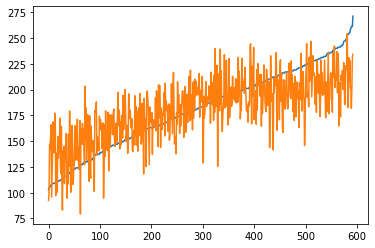

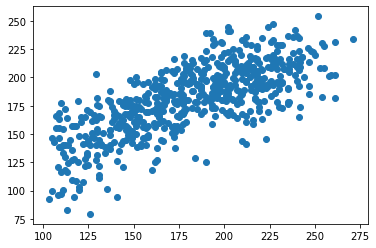

In [46]:
import matplotlib.pyplot as plt
import math

# y = X_train[:,0]
# idcs = torch.arange(0,len(y))
# yPred = maskgcn([True, idcs]).detach().numpy().flatten()

y = X_all[:,0]
yPred = agesPredCNN
print()    
    
idcs = np.argsort(y)
yPred = yPred[idcs]
y = y[idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()

In [47]:
# Get standard deviations

rmse = np.zeros(10)
mae = np.zeros(10)
corr = np.zeros(10)

idx = 0
for trainIdcs, testIdcs in groups:
    y = X_all[testIdcs,0]
    yPred = agesPredCNN[testIdcs]
    
    corr[idx] = np.corrcoef(y, yPred)[0,1]
    rmse[idx] = (np.sum((y-yPred)**2)/len(y))**0.5/12
    mae[idx] = np.sum(np.abs(y-yPred))/12/len(y)
   
    idx += 1
    
print(np.mean(rmse))
print(np.std(rmse))
print(np.mean(mae))
print(np.std(mae))
print(np.mean(corr))
print(np.std(corr))

2.2252949810043177
0.20994778608855033
1.800514958358305
0.15778314952364011
0.7285636208288463
0.06116345871121132


In [48]:
# Save predictions

with open('../../Work/Abstract/PaperBin/CNN-5-Predictions-3-Emoid.bin', 'wb') as f:
    pickle.dump(agesPredCNN, f)
    
torch.save(cnn.state_dict(), '../../Work/Abstract/PaperBin/CNN-5-Model-3-Emoid.bin',)
    
print('Complete')

Complete


In [50]:
# Check predictions

import pickle
import numpy as np

with open('../../Work/Abstract/PaperBin/CNN-5-Predictions-3-Emoid.bin', 'rb') as f:
    check = pickle.load(f)
    
rmse = np.zeros(10)
mae = np.zeros(10)
corr = np.zeros(10)

idx = 0
for trainIdcs, testIdcs in groups:
    y = X_all[testIdcs,0]
    yPred = check[testIdcs]
    
    corr[idx] = np.corrcoef(y, yPred)[0,1]
    rmse[idx] = (np.sum((y-yPred)**2)/len(y))**0.5/12
    mae[idx] = np.sum(np.abs(y-yPred))/12/len(y)
   
    idx += 1
    
print(np.mean(rmse))
print(np.std(rmse))
print(np.mean(mae))
print(np.std(mae))
print(np.mean(corr))
print(np.std(corr))

2.2252949810043177
0.20994778608855033
1.800514958358305
0.15778314952364011
0.7285636208288463
0.06116345871121132


torch.Size([264, 264])


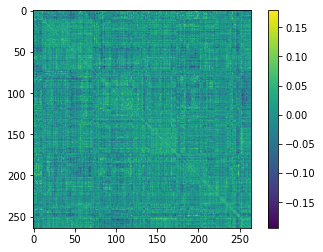

In [29]:
idx = 0
w1 = mlp.fc1.weight[0,idx*(nRoi*nRoi):(idx+1)*(nRoi*nRoi)].detach().cpu().reshape(nRoi,nRoi)
print(w1.shape)
plt.imshow(w1)
plt.colorbar()
plt.show()

In [170]:
with open('../../Work/Abstract/PaperBin/MLP-5-Weights-3-Emoid.bin', 'wb') as f:
    pickle.dump(mlp.fc1.weight.detach().cpu().numpy(), f)
    
print('Complete')

Complete
